In [1]:
import Higgs
from Higgs.tools.ImplementationUtils import readHEPDataCsv, implementMeasurement
from Higgs.tools.MeasurementValidation import *
from Higgs import signals as HS
import pandas as pd
import numpy as np


## ATLAS + CMS Run1 combined rate measurement [1606.02266](https://arxiv.org/abs/1606.02266)

The SM rate uncertainties are from the predicted column in tabe 8. The ZZ and
gamgam channels are treated as mass sensitive corresponding to the combined mass
measurement [1503.07589](https://arxiv.org/abs/1503.07589). 

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1468068/Table%201/1/csv"
)


def regulariseBinName(name):
    return (
        name.translate({ord(c): None for c in ("$", "\\", "{", "}", "^")})
        .replace("sigma_", "")
        .replace("mathrmB", "")
        .replace("mathrm", "")
        .replace("cdot", "_")
        .replace("gamma", "gam")
        .replace("ggF", "ggH")
        .replace("VBF", "vbfH")
        .replace("WH", "HW")
        .replace("ZH", "HZ")
        .replace("ttH", "Htt")
    )


dfObs = (
    dfs[0]
    .set_index("Channel")
    .rename(index=regulariseBinName, columns={"SIG [PB]": "obs"})
)
dfObs["obs+"] = dfObs.obs + np.sqrt(dfObs["stat +"] ** 2 + dfObs["sys +"] ** 2)
dfObs["obs-"] = dfObs.obs - np.sqrt(dfObs["stat -"] ** 2 + dfObs["sys -"] ** 2)
df = dfObs[["obs", "obs+", "obs-"]].copy()

dfExp = dfs[1].set_index("Channel").rename(index=regulariseBinName)
df["exp"] = dfExp["SIG [PB]"]
smUnc = pd.Series(
    {
        "ggH_gamgam": 5e-3,
        "ggH_ZZ": 60e-3,
        "ggH_WW": 0.5,
        "ggH_tautau": 140e-3,
        "vbfH_gamgam": 0.2e-3,
        "vbfH_ZZ": 2e-3,
        "vbfH_WW": 0.017,
        "vbfH_tautau": 6e-3,
        "HW_gamgam": 0.09e-3,
        "HW_WW": 0.007,
        "HW_tautau": 2.8e-3,
        "HW_bb": 0.017,
        "HZ_gamgam": 0.06e-3,
        "HZ_WW": 0.005,
        "HZ_tautau": 1.8e-3,
        "HZ_bb": 0.012,
        "Htt_gamgam": 0.035e-3,
        "Htt_WW": 0.0032,
        "Htt_tautau": 1e-3,
        "Htt_bb": 0.008,
    }
)
df["exp+"] = df.exp + smUnc
df["exp-"] = df.exp - smUnc

bins = {
    name: {
        "ref": [r["exp-"], r["exp"], r["exp+"]],
        "obs": [r["obs-"], r["obs"], r["obs+"]],
        "process": {"channels": [name.split("_")]},
    }
    for name, r in df.iterrows()
}
for k, bin in bins.items():
    if k.endswith("WW"):
        bin["massResolution"] = 5
    elif k.endswith("ZZ") or k.endswith("gamgam"):
        bin["massResolution"] = 0.24
        bin["massSensitive"] = True

    if k.startswith("ggH"):
        bin["process"]["channels"].append(["bbH", bin["process"]["channels"][0][1]])
    elif k.startswith("Htt"):
        bin["process"]["channels"] += [
            [p, bin["process"]["channels"][0][1]] for p in ("schanHt", "tchanHt", "HtW")
        ]

dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1468068/Table%2018/1/csv"
)
corrMat = pd.concat(
    [
        v.droplevel(1).rename(columns={"Correlation": k})
        for k, v in dfs[0]
        .set_index([r"$\sigma_i\cdot\mathrm{B}^f$", r"$\sigma_j\cdot\mathrm{B}^k$"])
        .rename(index=regulariseBinName)
        .groupby(r"$\sigma_j\cdot\mathrm{B}^k$")
    ],
    axis=1,
)

measFile = implementMeasurement(
    "1606.02266",
    "https://doi.org/10.17182/hepdata.78403.v1/t1, https://doi.org/10.17182/hepdata.78403.v1/t18",
    bins,
    prefix="run1_rates",
    corrMatExp=corrMat,
    referenceMass=125.09,
    luminosity=20 + 5,
    massResolution=20,
)


Multiple different luminosity values: [20.0, 5.0] using 20.0 unless you set it manually
Looks good. Saving this to run1_rates_LHC8_LHCComb_25.json


Comparison to the HS-2 result, matches very well (slight differences from different handling of EW corrections).

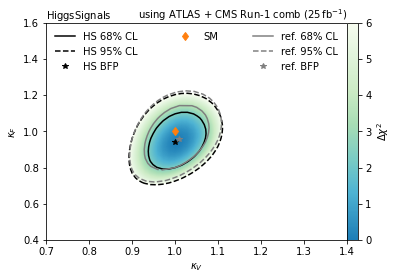

In [3]:
meas = HS.Measurement(measFile, HS.MeasurementOptions(ignoreTheoryUncertainties=True))
fig, ax = validateMeasurementKappa(
    meas,
    np.linspace(0.4, 1.6),
    np.linspace(0.7, 1.4),
    "Run-1 comb",
    official={
        68: np.array(
            [
                [0.96, 0.94329925, 0.93644489, 0.93073516, 0.92885391, 0.92831969]
                + [0.92963975, 0.93160953, 0.93502075, 0.93938127, 0.94394571, 0.95]
                + [0.95924372, 0.96547745, 0.97560253, 0.99, 1.01, 1.03891149, 1.05]
                + [1.06224393, 1.07029281, 1.07460004, 1.07797375, 1.07884302, 1.077657]
                + [1.07530467, 1.07028528, 1.06515194, 1.05943204, 1.05185663]
                + [1.0429532, 1.03489903, 1.02333741, 1.01027954, 0.99915816, 0.97],
                [0.78895209, 0.80670075, 0.82355511, 0.85, 0.87114609, 0.9, 0.92963975]
                + [0.95, 0.97502075, 1.0, 1.02, 1.04285813, 1.07, 1.08452255]
                + [1.10439747, 1.12543419, 1.14174584, 1.14108851, 1.13204897]
                + [1.11224393, 1.09029281, 1.07, 1.04202625, 1.02, 0.992343, 0.97]
                + [0.94028528, 0.92, 0.90056796, 0.88, 0.86, 0.84510097]
                + [0.82666259, 0.80972046, 0.79915816, 0.78676587],
            ]
        ),
        95: np.array(
            [
                [1.03811754, 1.02577353, 1.01, 0.99200276, 0.97819966, 0.95380321]
                + [0.93382256, 0.91700207, 0.90730803, 0.90132597, 0.89811416]
                + [0.89569355, 0.89441992, 0.89441068, 0.89518482, 0.89668954]
                + [0.89909191, 0.90150602, 0.90519428, 0.90953584, 0.91373524]
                + [0.91873037, 0.9254336, 0.93250303, 0.94063901, 0.94976306]
                + [0.96028111, 0.97230912, 0.98257342, 1.003308, 1.02335466, 1.04420774]
                + [1.06463865, 1.08, 1.0899389, 1.095982, 1.10061103, 1.10390136]
                + [1.10654417, 1.10760075, 1.10739716, 1.10566152, 1.1024868]
                + [1.09891347, 1.09440959, 1.08720899, 1.08014914, 1.07259908]
                + [1.06, 1.05278552, 1.04],
                [0.79188246, 0.77422647, 0.75465606, 0.73799724, 0.72819966]
                + [0.72, 0.72382256, 0.74, 0.76, 0.78132597, 0.8, 0.82430645]
                + [0.85, 0.87558932, 0.9, 0.92331046, 0.95, 0.97, 0.99480572]
                + [1.02, 1.04, 1.06126963, 1.0854336, 1.10749697, 1.12936099]
                + [1.15, 1.16971889, 1.18769088, 1.2, 1.216692, 1.22335466]
                + [1.22, 1.20463865, 1.18259967, 1.16, 1.14, 1.12061103, 1.1]
                + [1.07345583, 1.05, 1.02739716, 1.0, 0.9724868, 0.95108653, 0.93]
                + [0.90279101, 0.88, 0.86, 0.83096006, 0.81721448, 0.79457093],
            ]
        ),
        "BF": (1.01, 0.96),
    },
)


## ATLAS & CMS combined mass measurement [1503.07589](https://arxiv.org/abs/1503.07589)

**!! Individual ATLAS & CMS Higgs mass measurements replaced by PDG combination !!**

In [4]:
# from itertools import product

# prods = ["ggH", "bbH", "vbfH", "HW", "HZ", "Htt", "schanHt", "tchanHt", "HtW"]

# central = 125.09
# unc = 0.24
# measFile = implementMeasurement(
#     "1503.07589",
#     "https://arxiv.org/abs/1503.07589",
#     {
#         "gamgam_4l_comb": {
#             "process": {
#                 "channels": [list(x) for x in product(prods, ["gamgam", "ZZ"])]
#             },
#             "obsMass": [central - unc, central, central + unc],
#         },
#     },
#     prefix="run1_mass",
#     referenceMass=central,
#     luminosity=20 + 5,
#     massResolution=unc,
#     collider="LHC8",
#     experiment="LHCComb",
# )


Looks good. Saving this to run1_mass_LHC8_LHCComb_25.json


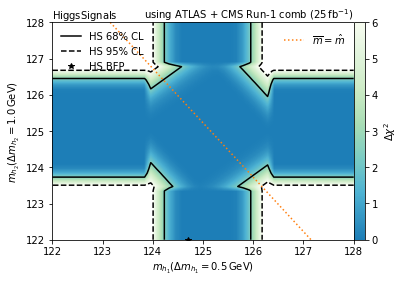

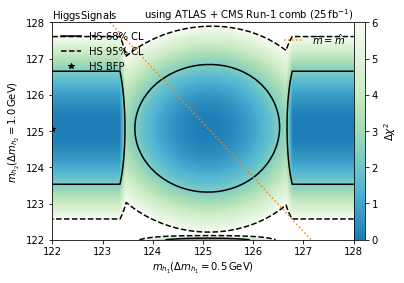

In [5]:
# for pdf in HS.PDF.__members__:
#     fig, ax = validateMassMeasurement2Higgses(
#         HS.Measurement(measFile, options=HS.MeasurementOptions(theoryMassUncPDF=pdf)),
#         ("LHC8", "ggH", "gamgam"),
#         m1Range=np.linspace(122, 128),
#         description="Run-1 comb",
#         rateRatio=1.5,
#         dm1=0.5,
#     )
